longitudinal analysis with partial volume corrected PET values

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import statsmodels.formula.api as smf
import patsy
from scipy.stats import zscore
import tableone as tb
import warnings

warnings.simplefilter(action='ignore')

from src.connectomics.atlases import get_dk_rois
from src.analysis.misc import set_plot_style

set_plot_style(dpi=150)
ROIs = get_dk_rois()

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))
df_dir = os.path.join(data_dir, 'datasets')

# out
media_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'media'))

plot_dir = os.path.join(media_dir, '_plots')
os.makedirs(plot_dir, exist_ok=True)

In [2]:
# LONG
ld_grp_col = 'tau_positive_bas'
amy_prefix = 'fgc'
tau_prefix = 'tgic'

df_ld = pd.read_csv(os.path.join(df_dir, f'bf2_tau_asymmetry_ad_long_{tau_prefix}_{amy_prefix}.csv'), low_memory=False, index_col=0)
df_ld['apoe4_count'] = df_ld['apoe_genotype_baseline_variable'].astype(str).apply(lambda x: np.nan if x is np.nan else sum(int(i == '4') for i in x))
# df_ld['gender_baseline_variable'] = df_ld['gender_baseline_variable'].map({0.0: 'M', 1.0: 'F'})

# sort by id and age
df_ld = df_ld.sort_values(['mid', 'age'])

# drop timepoints which dont have tau data and subjects with not multiple timepoints
df_ld = df_ld.dropna(subset=f'{tau_prefix}_temporal_meta')
df_ld = df_ld[df_ld.groupby('mid')['mid'].transform('count') > 1]

# subjects who have more than 3 timepoints, in case the first timepoint doesnt have amyPET, set the second timepoint as first if that one has
def adjust_timepoints(group, column, min_length=3):
    if pd.isna(group.iloc[0][column]):
        if len(group) >= min_length:
            if pd.notna(group.iloc[1][column]):
                group = group.iloc[1:].reset_index(drop=True)
    return group
df_ld = df_ld.groupby('mid', as_index=False, group_keys=False).apply(lambda x: adjust_timepoints(x, f'{amy_prefix}_global')).reset_index(drop=True)
print(f"N (multiple tau-PET scans) = {len(df_ld['mid'].unique())} (all timepoints = {len(df_ld)})")

# df with available baseline amyPET
df_ld_a = df_ld[df_ld.groupby('mid')[f'{amy_prefix}_global'].transform(lambda x: x.iloc[0]).notna()]
print(f"N (has baseline amy-PET) = {len(df_ld_a['mid'].unique())} (all timepoints = {len(df_ld_a)})")

# set baseline values for all timepoints
df_ld_a[ld_grp_col] = df_ld_a.groupby('mid')['tau_positive'].transform(lambda x: x.iloc[0])
df_ld_a['time'] = df_ld_a.groupby('mid')['age'].transform(lambda x: x - x.iloc[0])
df_ld_a['age_bas'] = df_ld_a.groupby('mid')['age'].transform(lambda x: x.iloc[0])
df_ld_a[f'{amy_prefix}_global_bas'] = df_ld_a.groupby('mid')[f'{amy_prefix}_global'].transform(lambda x: x.iloc[0])
df_ld_a[f'{tau_prefix}_temporal_meta_bas'] = df_ld_a.groupby('mid')[f'{tau_prefix}_temporal_meta'].transform(lambda x: x.iloc[0])

# add the amount of timepoints for tau PET and if has amyloid PET at a timepoint
df_ld_a['tp_total'] = df_ld_a.groupby('mid')['mid'].transform('count')
df_ld_a['tp_tauPET'] = df_ld_a.groupby('mid')[f'{tau_prefix}_temporal_meta'].transform(lambda x: x.notna().sum())
df_ld_a['has_amyPET'] = df_ld_a.groupby('mid')[f'{amy_prefix}_global_bas'].transform(lambda x: x.notna().astype(int))

# divide to tau positive and negative samples
df_ld_a_tneg = df_ld_a[df_ld_a[ld_grp_col]==False]
df_ld_a_tpos = df_ld_a[df_ld_a[ld_grp_col]==True]

df_ld_a_tnegpos = df_ld_a_tneg.groupby('mid').filter(lambda x: x['tau_positive'].iloc[1:].any())
df_ld_a_tnegneg = df_ld_a_tneg.groupby('mid').filter(lambda x: ~x['tau_positive'].any())

plots_rois_dict = {
    'A+': {
        'df': df_ld_a, 
        'rois': {
            'global': 'Global', 
        }
    },
    'A+T-': {
        'df': df_ld_a_tneg, 
        'rois': {
            'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI'
        }
    },
    'A+T+': {
        'df': df_ld_a_tpos, 
        'rois': {
            'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI'
        }
    },
    'A+T- to A+T-': {
        'df': df_ld_a_tnegneg, 
        'rois': {
            'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI'
        }
    },
    'A+T- to A+T+': {
        'df': df_ld_a_tnegpos, 
        'rois': {
            'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI'
        }
    }
}

for grp, g_data in plots_rois_dict.items():
    df_ = g_data['df']
    print(f"N ({grp}) = {len(df_['mid'].unique())} (all timepoints = {len(df_)})")

# print(f"N (multiple tau-PET) = {len(df_ld_bas)} (all timepoints = {len(df_ld)})")
# # first timepoints only
# df_ld_bas = df_ld.drop_duplicates(subset='mid', keep='first')
# print(f"N (multiple tau-PET) = {len(df_ld_bas)} (all timepoints = {len(df_ld)})")
# df_ld_a_bas = df_ld_a.drop_duplicates(subset='mid', keep='first')
# print(f"N (multiple tau-PET + baseline amy-PET) = {len(df_ld_a_bas)} (all timepoints = {len(df_ld_a)})")

N (multiple tau-PET scans) = 402 (all timepoints = 949)
N (has baseline amy-PET) = 289 (all timepoints = 707)
N (A+) = 289 (all timepoints = 707)
N (A+T-) = 173 (all timepoints = 436)
N (A+T+) = 116 (all timepoints = 271)
N (A+T- to A+T-) = 133 (all timepoints = 321)
N (A+T- to A+T+) = 40 (all timepoints = 115)


N (A+) = 289 (all timepoints = 707)
avg followup years = 2.874
                 Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     tgic_global_LI
No. Observations:     707         Method:                 REML          
No. Groups:           289         Scale:                  0.0692        
Min. group size:      2           Log-Likelihood:         -564.4030     
Max. group size:      5           Converged:              No            
Mean group size:      2.4                                               
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.057    0.060 -0.954 0.340 -0.175  0.060
time                           0.008    0.013  0.579 0.563 -0.019  0.034
age_bas                       -0.014    0.043 -0.330 0.741 -0.099  0.071
gender

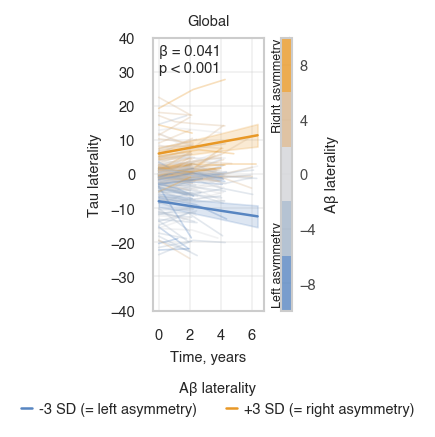

N (A+T-) = 173 (all timepoints = 436)
avg followup years = 3.010
                 Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   tgic_cho_com_I_II_LI
No. Observations:   436       Method:               REML                
No. Groups:         173       Scale:                0.5020              
Min. group size:    2         Log-Likelihood:       -590.4314           
Max. group size:    5         Converged:            Yes                 
Mean group size:    2.5                                                 
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.019    0.096 -0.197 0.844 -0.208  0.170
time                           0.029    0.035  0.827 0.408 -0.040  0.099
age_bas                       -0.015    0.069 -0.221 0.825 -0.151  0.120
gend

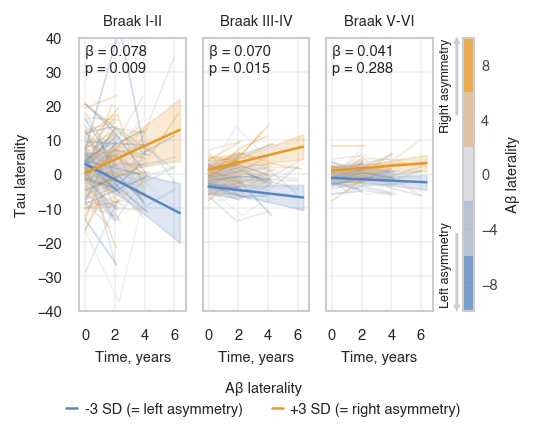

N (A+T+) = 116 (all timepoints = 271)
avg followup years = 2.670
                 Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   tgic_cho_com_I_II_LI
No. Observations:   271       Method:               REML                
No. Groups:         116       Scale:                0.2832              
Min. group size:    2         Log-Likelihood:       -351.6567           
Max. group size:    4         Converged:            Yes                 
Mean group size:    2.3                                                 
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.025    0.115  0.214 0.831 -0.201  0.250
time                          -0.030    0.045 -0.660 0.509 -0.117  0.058
age_bas                       -0.059    0.083 -0.712 0.477 -0.221  0.103
gend

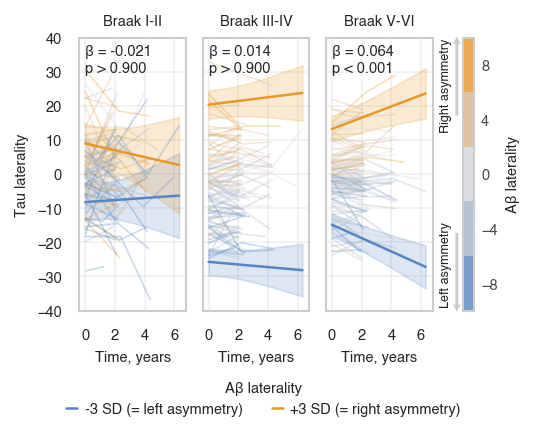

N (A+T- to A+T-) = 133 (all timepoints = 321)
avg followup years = 2.823
                 Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   tgic_cho_com_I_II_LI
No. Observations:   321       Method:               REML                
No. Groups:         133       Scale:                0.4399              
Min. group size:    2         Log-Likelihood:       -429.3211           
Max. group size:    4         Converged:            Yes                 
Mean group size:    2.4                                                 
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                      0.011    0.108  0.101 0.920 -0.201  0.222
time                           0.014    0.042  0.327 0.743 -0.068  0.096
age_bas                       -0.031    0.078 -0.400 0.689 -0.184  0.

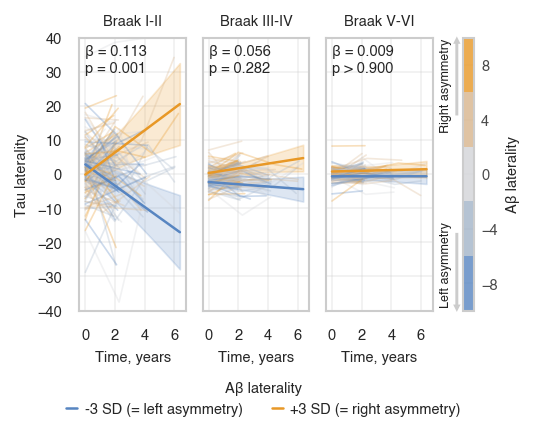

N (A+T- to A+T+) = 40 (all timepoints = 115)
avg followup years = 3.631
                 Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   tgic_cho_com_I_II_LI
No. Observations:   115       Method:               REML                
No. Groups:         40        Scale:                0.6786              
Min. group size:    2         Log-Likelihood:       -168.2300           
Max. group size:    5         Converged:            Yes                 
Mean group size:    2.9                                                 
------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------
Intercept                     -0.129    0.227 -0.571 0.568 -0.573  0.315
time                           0.072    0.073  0.982 0.326 -0.071  0.214
age_bas                        0.043    0.161  0.265 0.791 -0.273  0.3

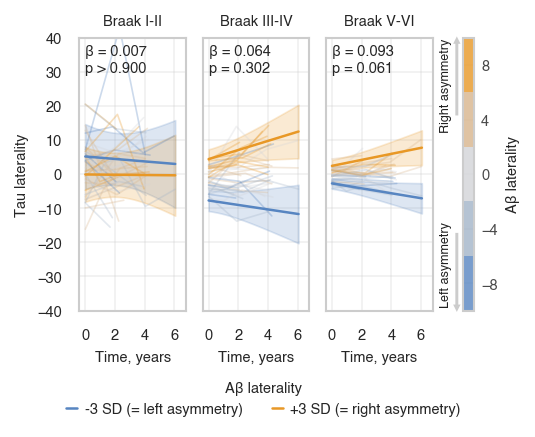

In [3]:
posthoc = True

ROIs_dict = {
    'global': 'Global', 
    'cho_com_I_II': 'Braak I-II', 'cho_com_III_IV': 'Braak III-IV', 'cho_com_V_VI': 'Braak V-VI',
}

set_plot_style(dpi=150)
statann_kwargs = dict(fontsize=7, color='#494949')
line_kwargs = dict(lw=0.8, alpha=0.3)
colors = ['#5785C1FF', '#A3B4C8', '#D3D4D8FF', '#D8B58C', '#E89826']
cmap = ListedColormap(colors, name="BlueToGrayToOrange")

for grp, grp_data in plots_rois_dict.items():

    df_g = grp_data['df']
    rois_dict = grp_data['rois']

    print(f"N ({grp}) = {len(df_g['mid'].unique())} (all timepoints = {len(df_g)})")

    _w = 110/4.1
    _w_ratio = [*[1] * len(rois_dict), 0.1]

    fig = plt.figure(figsize=(_w*(len(rois_dict)+0.1)/25.4, 60/25.4))
    gs = fig.add_gridspec(1, len(rois_dict)+1, width_ratios=_w_ratio, wspace=0.2)
    axs = []
    for i in range(len(rois_dict)):
        axs.append(fig.add_subplot(gs[0, i]))

    for i, (ROI, ROI_name) in enumerate(rois_dict.items()):
        
        # define the tau and ab columns
        tau_reg = f'{tau_prefix}_{ROI}_LI'
        amy_reg = f'{amy_prefix}_{ROI}_LI'

        df_roi = df_g.copy()

        tau_lim, amy_lim = [-40, 40], [-10, 10]

        df_lme = df_roi[['mid', 'time', 'age_bas', 'gender_baseline_variable', tau_reg, amy_reg]].copy()
        df_lme[f'{amy_reg}_bas'] = df_lme.groupby('mid')[amy_reg].transform(lambda x: x.iloc[0])

        avg_fup = df_lme.groupby('mid')['time'].transform(lambda x: x.iloc[-1:]).mean()
        if i==0: print(f'avg followup years = {avg_fup:.3f}')

        # Store original values before z-scoring
        orig_means = df_lme[['age_bas', f'{tau_reg}', f'{amy_reg}_bas']].mean()
        orig_stds = df_lme[['age_bas', f'{tau_reg}', f'{amy_reg}_bas']].std()

        # Z-score the continuous variables
        cols_to_zscore = ['age_bas', f'{tau_reg}', f'{amy_reg}_bas']
        df_lme_z = df_lme.copy()
        df_lme_z[cols_to_zscore] = df_lme_z[cols_to_zscore].apply(zscore)

        # fit the LME
        formula = f"{tau_reg} ~ time * (age_bas + gender_baseline_variable + {amy_reg}_bas)"
        model = smf.mixedlm(formula, data=df_lme_z, groups="mid", re_formula="~time")
        results = model.fit()

        print(results.summary())
        
        ### plotting

        ax = axs[i]

        # define time range for prediction
        time_min, time_max = df_lme['time'].min(), df_lme['time'].max()
        time_range = np.linspace(time_min, time_max, 100)

        # define two amyloid LI values for prediction
        amy_minmax = [-3*df_lme[f'{amy_reg}_bas'].std(), 3*df_lme[f'{amy_reg}_bas'].std()]
        colors = [cmap(0.01), cmap(0.99)]
        labels = [f'-3 SD (= left asymmetry)', f'+3 SD (= right asymmetry)']

        # get covariance matrix of the fixed effects parameters
        fixed_effects_cov = results.cov_params().iloc[:8, :8] #[:6, :6]

        # plot the individual datapoints as spaghetti plot
        for subject in df_lme['mid'].unique():
            subject_data = df_lme[df_lme['mid'] == subject]
            ax.plot(subject_data['time'], subject_data[tau_reg],
                    c=cmap((subject_data[f'{amy_reg}_bas'].mean() - amy_lim[0])/(amy_lim[1] - amy_lim[0])),
                    **line_kwargs)
        
        # plt.ylim([-1.1*df_lme[tau_reg].abs().max(), 1.1*df_lme[tau_reg].abs().max()])
        ax.set_ylim(tau_lim)

        # run prediction with two predefined amyloid LIs
        for amy_val, color, label in zip(amy_minmax, colors, labels):
            # Create prediction data (z-scored)
            temp_data = pd.DataFrame({
                'time': time_range,
                'age_bas': [(df_lme['age_bas'].mean() - orig_means['age_bas'])/orig_stds['age_bas']] * len(time_range),
                'gender_baseline_variable': [df_lme['gender_baseline_variable'].mode()[0]] * len(time_range),
                f'{amy_reg}_bas': [(amy_val - orig_means[f'{amy_reg}_bas'])/orig_stds[f'{amy_reg}_bas']] * len(time_range)
            })

            # Get predictions and transform back to original scale
            pred_mean = results.predict(temp_data)
            pred_mean_orig = pred_mean * orig_stds[f'{tau_reg}'] + orig_means[f'{tau_reg}']

            # Calculate confidence intervals
            design_matrix = np.asarray(patsy.dmatrix(formula.split('~')[1], data=temp_data))
            prediction_var = np.diag(design_matrix @ fixed_effects_cov @ design_matrix.T)
            se = np.sqrt(prediction_var)

            # Transform CIs back to original scale
            lower_ci = (pred_mean - 1.96 * se) * orig_stds[f'{tau_reg}'] + orig_means[f'{tau_reg}']
            upper_ci = (pred_mean + 1.96 * se) * orig_stds[f'{tau_reg}'] + orig_means[f'{tau_reg}']

            # Plot
            ax.plot(time_range, pred_mean_orig, color=color, linewidth=1.2, label=label)
            ax.fill_between(time_range, lower_ci, upper_ci, color=color, alpha=0.2)
        
        if i > 0:
            ax.set_ylabel('')
            ax.set_yticklabels([])
        else:
            ax.set_ylabel('Tau laterality')
        ax.set_title(ROI_name)

        # add annotation of the interaction effect
        interaction_idx = results.model.exog_names.index('time:' + f'{amy_reg}_bas')
        beta = results.params[interaction_idx]
        pval = results.pvalues[interaction_idx]
        if posthoc: 
            pval = pval * len(rois_dict) # bonferroni correction
            if pval < 0.001: ptext = '< 0.001'
            elif pval > 0.900: ptext = '> 0.900'
            else: ptext = f'= {pval:.3f}'
        # ptext = '< 0.001' if pval < 0.001 else f'= {pval:.3f}'
        ax.text(0.055, 0.975, f'β = {beta:.3f}\np {ptext}',
                transform=ax.transAxes, verticalalignment='top')

        # last iteration
        if i == len(rois_dict)-1:
            # asymmetry direction arrows
            yrange = tau_lim[1] - tau_lim[0]
            arrowprops_kwargs = dict(arrowstyle='simple', color='#CCCCCC', lw=0.01)
            arrowtext_kwargs = dict(color='#212121', rotation=90, fontsize=6, ha='center', va='center', 
                                    transform=ax.get_yaxis_transform())
            ax.annotate('', xy=(1.225, tau_lim[1] + yrange*0.02), xytext=(1.225, tau_lim[1] - yrange*0.3),
                        xycoords=('axes fraction', 'data'), arrowprops=arrowprops_kwargs)
            ax.text(1.125, tau_lim[1] - yrange*0.175, 'Right asymmetry', **arrowtext_kwargs)
            ax.annotate('', xy=(1.225, tau_lim[0] - yrange*0.02), xytext=(1.225, tau_lim[0] + yrange*0.3),
                        xycoords=('axes fraction', 'data'), arrowprops=arrowprops_kwargs)
            ax.text(1.125, tau_lim[0] + yrange*0.17, 'Left asymmetry', **arrowtext_kwargs)

            # colorbar
            cax = fig.add_subplot(gs[0, -1])
            norm2 = plt.Normalize(amy_lim[0], amy_lim[1])

            colors2 = cmap(np.linspace(0, 1, cmap.N))
            colors2[:, -1] = 0.8#line_kwargs['alpha']  # Set alpha value for all colors
            transparent_cmap = matplotlib.colors.ListedColormap(colors2)
            
            sm = plt.cm.ScalarMappable(cmap=transparent_cmap, norm=norm2)
            cbar = plt.colorbar(sm, cax=cax, label='Aβ laterality')
            # cbar.locator = matplotlib.ticker.MaxNLocator(integer=True)
            cbar.locator = matplotlib.ticker.MultipleLocator(4)
            cbar.update_ticks()
            cbar.ax.tick_params(length=0, color='#CCCCCC', labelcolor='#494949')

            pos = cax.get_position()
            cax.set_position([pos.x0 + 0.028, pos.y0, pos.width, pos.height])
        
        ax.set_xlim([-0.4, 6.8])
        ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2))
        ax.set_xlabel('Time, years')
        
        if i == 0: handles, labels = ax.get_legend_handles_labels()

    plt.legend(handles, labels, loc='lower center', frameon=False, title='Aβ laterality', title_fontsize=7, ncol=2,
                handlelength=0.75, handletextpad=0.5, labelspacing=0.5, bbox_to_anchor=(0.5, -0.225), bbox_transform=fig.transFigure)

    plt.tight_layout()
    plt.savefig(os.path.join(plot_dir, f'LME_tau_ab_laterality_ld_pvc_{grp}_{list(rois_dict.keys())}.pdf'), format='pdf', bbox_inches='tight', dpi=300)
    plt.show()
    